![women_clothing](images/clothing.jpg)

Welcome to the world of e-commerce, where customer feedback is a goldmine of insights! In this project, you'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.

Let's get started!



## Before you start

In order to complete the project, you may wish to use the OpenAI API. You can create a developer account with OpenAI and store your API key as an environment variable. Instructions for these steps are outlined below.

## Load OpenAI API key from environment variables
These variables can be referenced globally throughout the project while keeping their values secret. Good for setting passwords in credentials.

In [151]:
# Initialize your API key
import os
openai_api_key = os.environ["OPENAI_API_KEY"]

## Install useful libraries

In [152]:
# Update OpenAI to 1.3
from importlib.metadata import version
try:
    assert version('openai') == '1.3.0'
except:
    !pip install openai==1.3.0
import openai

In [153]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [154]:
# --- Imports ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from openai import OpenAI
from sklearn.manifold import TSNE
from scipy.spatial import distance

import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [155]:
# --- Config ---
# Make sure your environment has OPENAI_API_KEY set, e.g.:
# os.environ["OPENAI_API_KEY"] = "sk-..."   # (better to set this outside the script)
EMBEDDING_MODEL = "text-embedding-3-small"


In [156]:
# --- 1) Load data (limit to 200 rows, drop missing review text) ---
reviews_df = pd.read_csv("womens_clothing_e-commerce_reviews.csv")
review_texts = reviews_df["Review Text"].dropna().tolist()

In [157]:
# --- 2) Create embeddings for reviews in ONE API call ---
client = OpenAI()  # uses OPENAI_API_KEY from env
resp = client.embeddings.create(model=EMBEDDING_MODEL, input=review_texts)
embeddings = [item.embedding for item in resp.data]  # <- list of vectors


In [158]:
# --- 3) Dimensionality reduction (t-SNE -> 2D) ---
def apply_tsne(embeddings_array):
    # Typical stable defaults for small datasets like 200 items
    tsne = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate=200)
    return tsne.fit_transform(embeddings_array)

embeddings_2d = apply_tsne(np.array(embeddings))  # <- required output


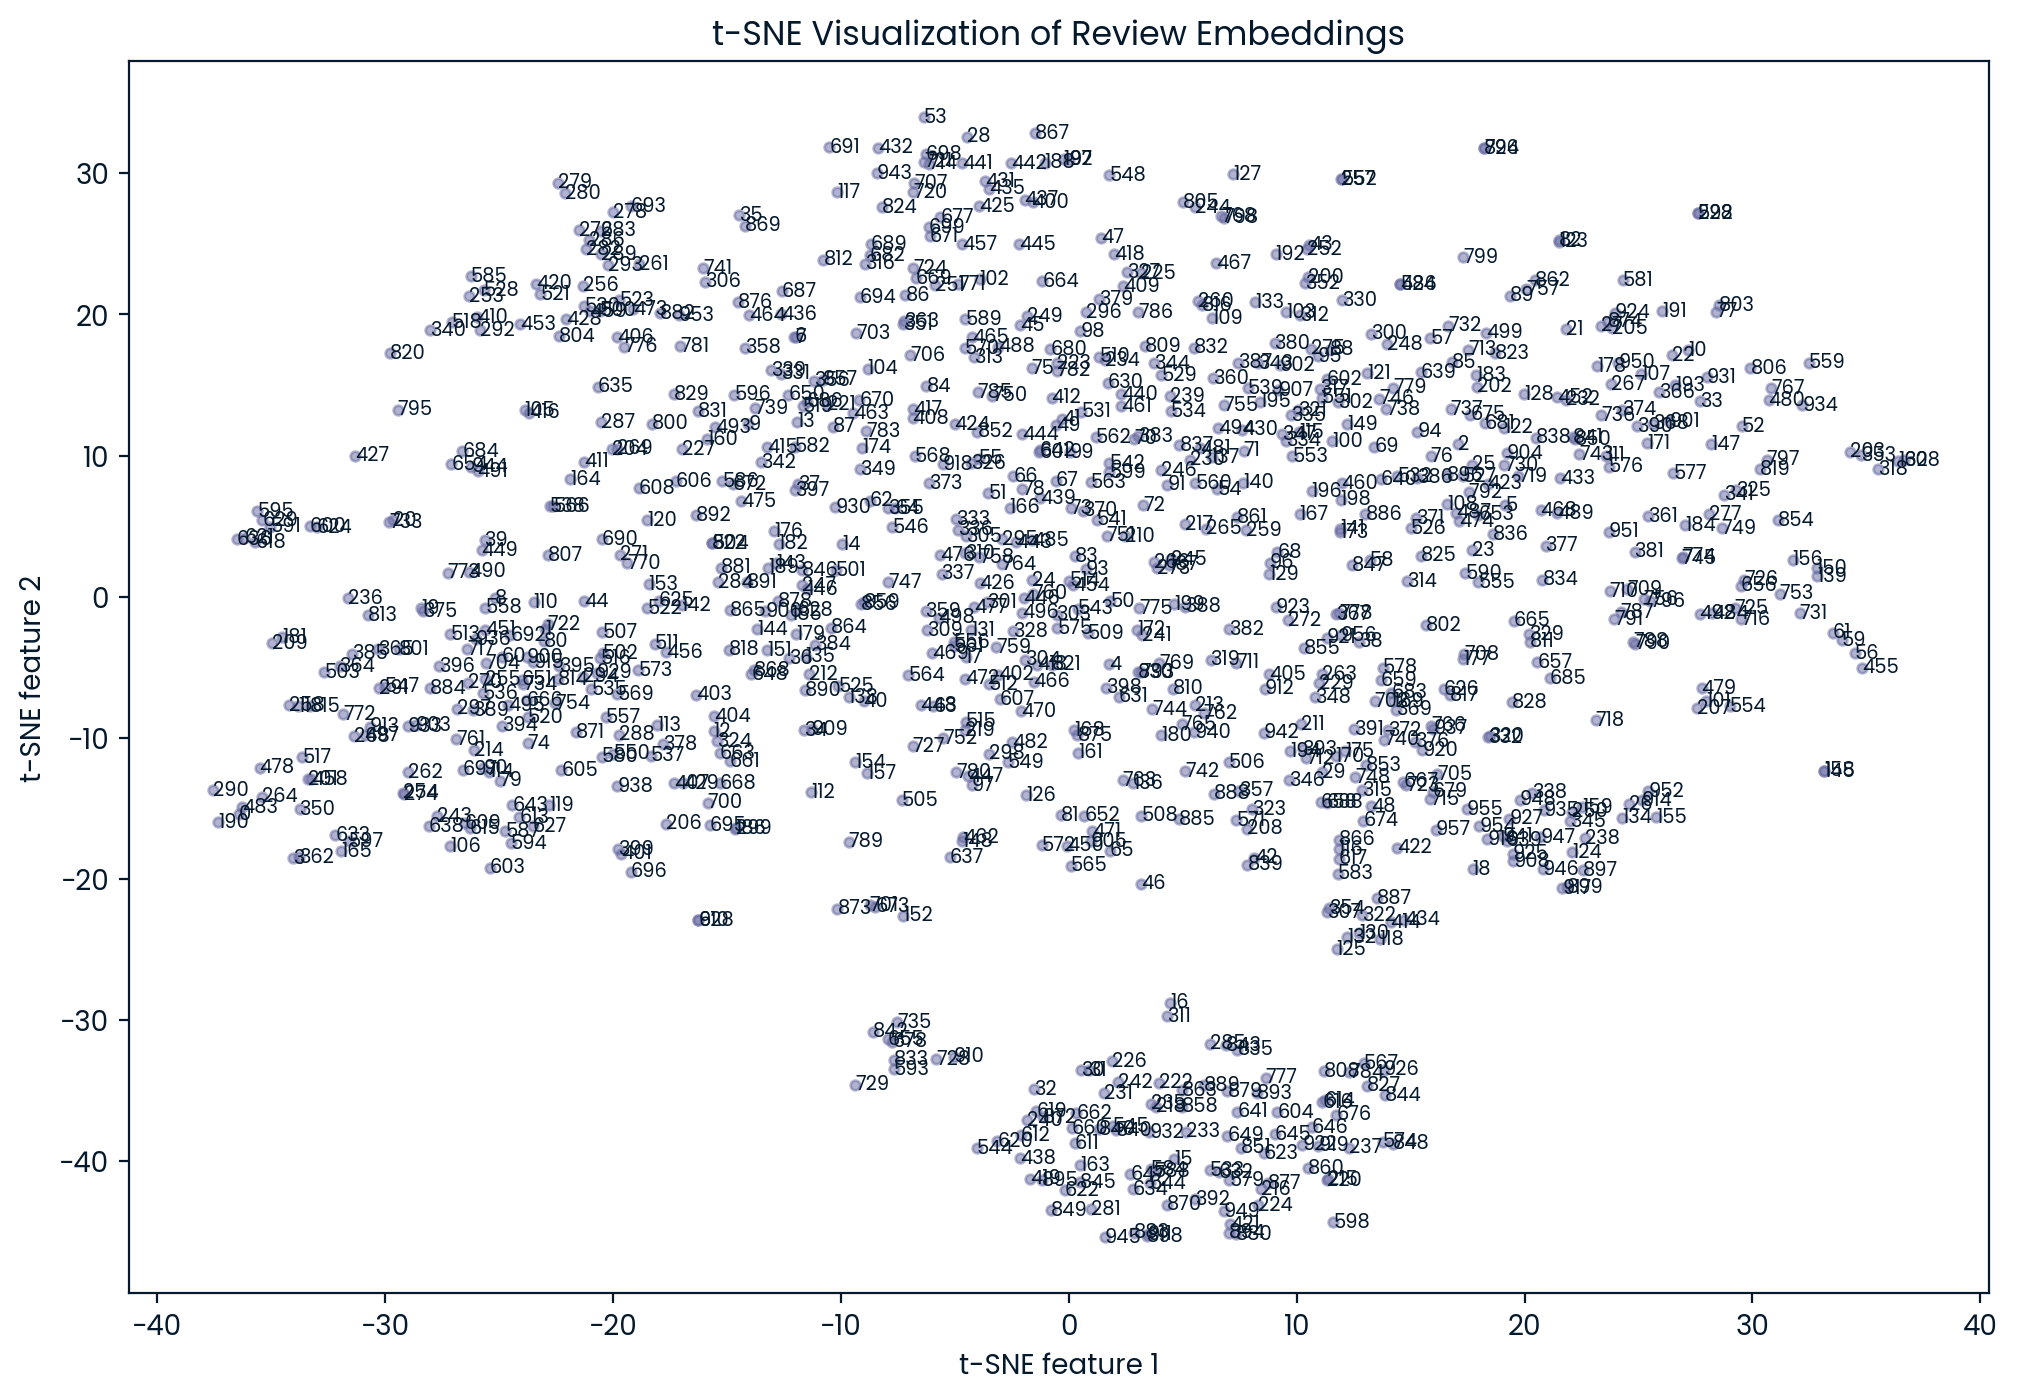

In [159]:
# --- 4) Plot the 2D visualization ---
def plot_tsne(tsne_results):
    plt.figure(figsize=(12, 8))
    # Fast scatter for all points
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5, s=12)
    # Optional: index labels (can get cluttered, so keep small font)
    for i, (x, y) in enumerate(tsne_results):
        plt.text(x, y, str(i), fontsize=7, va="center")
    plt.title("t-SNE Visualization of Review Embeddings")
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    plt.show()

plot_tsne(embeddings_2d)


In [160]:
# --- 5) Feedback categorization via category embeddings ---
categories = ["Quality", "Fit", "Style", "Comfort"]

cat_resp = client.embeddings.create(model=EMBEDDING_MODEL, input=categories)
category_embeddings = [item.embedding for item in cat_resp.data]

def categorize_feedback(text_embedding, category_embeddings, category_names):
    """
    Choose the category with the smallest cosine distance (i.e., highest similarity).
    """
    sims = [
        {"distance": distance.cosine(text_embedding, cat_emb), "index": i}
        for i, cat_emb in enumerate(category_embeddings)
    ]
    closest = min(sims, key=lambda x: x["distance"])  # <-- minimize distance, not index
    return category_names[closest["index"]]

feedback_categories = [
    categorize_feedback(emb, category_embeddings, categories) for emb in embeddings
]

In [161]:
# --- 6) Vector DB (Chroma) for similarity search ---
# PersistentClient stores data under a local directory (default: ./chroma)
chroma_client = chromadb.PersistentClient()

# Create a collection that automatically embeds new docs with OpenAI model
collection = chroma_client.create_collection(
    name="review_embeddings",
    embedding_function=OpenAIEmbeddingFunction(
        model_name=EMBEDDING_MODEL,
        api_key=os.environ["OPENAI_API_KEY"]
    )
)

# Add the raw review texts; embeddings will be computed server-side by the embedding_function
collection.add(
    documents=review_texts,
    ids=[str(i) for i in range(len(review_texts))]
)

def find_similar_reviews(input_text, vector_collection, n=3):
    """
    Query Chroma for the n most similar documents to 'input_text'
    using the collection's embedding function.
    """
    res = vector_collection.query(query_texts=[input_text], n_results=n)
    # res["documents"] is a list of lists; pick the first query’s results
    return res["documents"][0]

In [162]:
# --- 7) Similarity search example (required) ---
example_review = "Absolutely wonderful - silky and sexy and comfortable"
most_similar_reviews = find_similar_reviews(example_review, collection, n=3)  # <- required output
print("Most similar reviews:", most_similar_reviews)

Most similar reviews: ['Absolutely wonderful - silky and sexy and comfortable', 'Very comfortable and versatile. got lots of compliments.', 'This is a very comfortable and sexy sleep dress, the way it drapes. i can see that the type of fabric is not suitable for out and about activities and can catch on snags, etc. very easily. once i relegated it to the nightgown category it became my favorite item to wear and lounge in.']


In [163]:
# --- 8) Clean up (optional) ---
# If you want to persist the collection for later, skip deletion.
chroma_client.delete_collection(name="review_embeddings")